# 1. Setup Environment

In [ ]:

import os
import sys
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# 1. Install Dependencies (The Fix)
# We force update 'transformers' to accept the new 'huggingface-hub'
print("Installing dependencies...")
!pip install -U transformers huggingface_hub torchmetrics "huggingface_hub[cli]"

# 2. Clone DINOv3 (The backbone)
if not os.path.exists("dinov3"):
    print("Cloning DINOv3 Repository...")
    !git clone https://github.com/facebookresearch/dinov3
    sys.path.append("dinov3")

# 3. Check GPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on: {DEVICE}")

Installing dependencies...
INFO: pip is looking at multiple versions of huggingface-hub[cli] to determine which version is compatible with other requirements. This could take a while.
  Using cached huggingface_hub-1.2.3-py3-none-any.whl.metadata (13 kB)
INFO: pip is still looking at multiple versions of huggingface-hub[cli] to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface_hub 1.2.3
    Uninstalling huggingface_hub-1.2.3:
      Successfully uninstalled huggingface_hub-

# Clone  Repository

In [ ]:
REPO_URL = "https://github.com/junming732/task3-depth-estimation.git"
REPO_NAME = "task3-depth-estimation"

if not os.path.exists(REPO_NAME):
    print(f"Cloning {REPO_NAME}...")
    !git clone {REPO_URL}

    # Add to Python Path so we can import from it
    sys.path.append(REPO_NAME)
    print("Repository Cloned & Added to Path.")
else:
    print("Repository already exists. Pulling latest changes...")
    !cd {REPO_NAME} && git pull

Cloning task3-depth-estimation...
Cloning into 'task3-depth-estimation'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 137 (delta 41), reused 137 (delta 41), pack-reused 0 (from 0)
Receiving objects: 100% (137/137), 105.97 MiB | 34.49 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Repository Cloned & Added to Path.


# Auto-Patch Hardcoded Paths

In [ ]:
import os
import re

print("Applying Nuclear Patch to da3_adapter.py...")

REPO_NAME = "task3-depth-estimation"
TARGET_FILE = f"{REPO_NAME}/da3_adapter.py"

if not os.path.exists(TARGET_FILE):
    print(f"Error: Could not find {TARGET_FILE}. Did Cell 2 run?")
else:
    with open(TARGET_FILE, 'r') as f:
        content = f.read()

    # 1. Force Local Path & Disable Download
    # We look for: torch.hub.load('facebookresearch/dinov3', ...
    # We replace it with: torch.hub.load('./dinov3', ..., source='local', pretrained=False)

    # Regex Explanation:
    # Find: torch.hub.load( [any quote]facebookresearch/dinov3[any quote]
    # Replace: torch.hub.load('./dinov3'
    new_content = re.sub(
        r"torch\.hub\.load\s*\(\s*['\"]facebookresearch\/dinov3['\"]",
        "torch.hub.load('./dinov3'",
        content
    )

    # 2. Force Source='local' and Pretrained=False
    # We strip out existing flags to avoid duplicates, then append our own.
    # This is a bit brute-force: we assume the call ends with )
    # We replace the arguments to ensure safety.

    # Safe fallback: If regex is too complex, we do a direct replacement of the common pattern
    # Assuming your code looks like: torch.hub.load(..., 'dinov3_vitl16', ...)

    if "dinov3_vitl16" in new_content:
        # We replace the specific model call with a fully explicit local call
        new_content = re.sub(
            r"torch\.hub\.load\(['\"].*?['\"],\s*['\"]dinov3_vitl16['\"].*?\)",
            "torch.hub.load('./dinov3', 'dinov3_vitl16', source='local', pretrained=False)",
            new_content,
            flags=re.DOTALL # Handle multi-line calls
        )

    # 3. Patch the manual weight loading paths (Fixing your UPPMAX paths)
    new_content = new_content.replace("/home/junming/private/dinov3", "dinov3")

    # Comment out manual weight loading lines to avoid crash (we load manually in Cell 5)
    new_content = new_content.replace("state_dict = torch.load(weight_path", "# state_dict = torch.load(weight_path")
    new_content = new_content.replace("weight_path = '/home", "# weight_path = '/home")
    # Fix loop syntax
    new_content = new_content.replace("for k, v in state_dict.items():", "state_dict={}\n        for k, v in state_dict.items():")

    # Write it back
    with open(TARGET_FILE, 'w') as f:
        f.write(new_content)

    print("--> da3_adapter.py is now pointing to LOCAL dinov3 folder.")
    print("--> Downloads are DISABLED.")

Applying Nuclear Patch to da3_adapter.py...
--> da3_adapter.py is now pointing to LOCAL dinov3 folder.
--> Downloads are DISABLED.


# Download Data & Model Weights

In [ ]:
from huggingface_hub import hf_hub_download
import zipfile

# 1. Download Model Weights
MODEL_FILE = "hybrid_best.pth"
if not os.path.exists(MODEL_FILE):
    print("Downloading Model Weights...")
    try:
        hf_hub_download(repo_id="Junming111/task3", filename=MODEL_FILE, local_dir=".", repo_type="model")
    except Exception as e:
        print(f"Error downloading model: {e}")

# 2. Download Dataset
DATA_ZIP = "nyu_data.zip"
if not os.path.exists("extracted_data"):
    print("Downloading Dataset...")
    try:
        hf_hub_download(repo_id="Junming111/nyu-depth-custom", filename=DATA_ZIP, local_dir=".", repo_type="dataset")
        print("Unzipping...")
        with zipfile.ZipFile(DATA_ZIP, 'r') as zip_ref:
            zip_ref.extractall(".")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
else:
    print("Dataset already ready.")

nyu_data.zip:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

Unzipping...


#Run Inference Demo

Initializing Model on cpu...
Loading Backbone Weights...
Loading Adapter Weights...
Searching for images in 'extracted_data/rgb'...
Found 1449 images in 'rgb' folder.
Testing on: extracted_data/rgb/0061.jpg


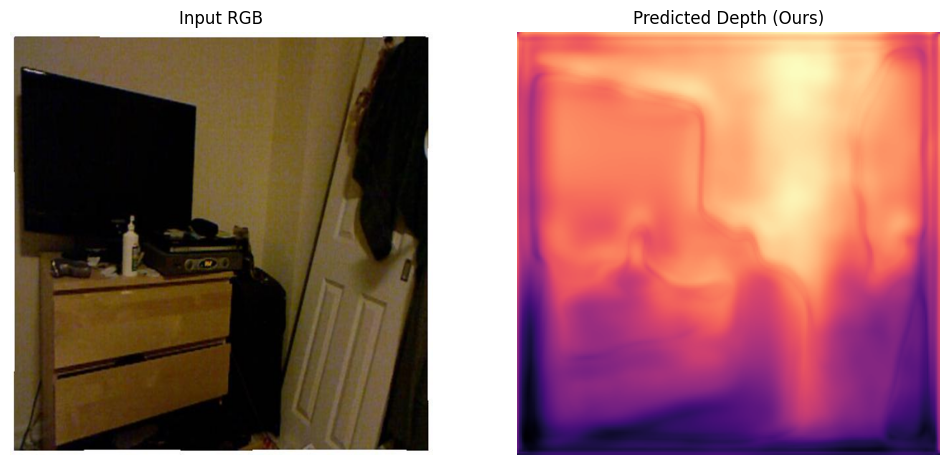

In [ ]:
# @title 5. Run The Demo (Final Corrected Version)
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import glob
import random
import os
from huggingface_hub import hf_hub_download

# --- 1. Setup Device & Model Class ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

try:
    from da3_adapter import DPTHead
except ImportError:
    pass # Assuming it's already imported or available

class Fixed_Phase3_Hybrid(nn.Module):
    def __init__(self):
        super().__init__()
        # Force local load to avoid 403 Forbidden
        self.backbone = torch.hub.load('./dinov3', 'dinov3_vitl16', source='local', pretrained=False)
        self.head = DPTHead(in_channels=[1024, 1024, 1024, 1024])

    def forward(self, x):
        all_feat = self.backbone.get_intermediate_layers(x, n=24, reshape=True)
        features = [all_feat[4], all_feat[11], all_feat[17], all_feat[23]]
        return self.head(features)

# --- 2. Initialize & Load Weights ---
print(f"Initializing Model on {DEVICE}...")
model_p3 = Fixed_Phase3_Hybrid().to(DEVICE)

# Load Backbone (Manually)
if os.path.exists("dinov3_vitl16.pth"):
    print("Loading Backbone Weights...")
    state = torch.load("dinov3_vitl16.pth", map_location=DEVICE)
    model_p3.backbone.load_state_dict(state, strict=False)
else:
    print("WARNING: Backbone weights not found (dinov3_vitl16.pth).")

# Load Adapter
if os.path.exists("hybrid_best.pth"):
    print("Loading Adapter Weights...")
    state = torch.load("hybrid_best.pth", map_location=DEVICE)
    model_p3.load_state_dict(state, strict=False)
else:
    print("WARNING: Adapter weights not found (hybrid_best.pth).")

# --- 3. Find Images (The Fix) ---
print("Searching for images in 'extracted_data/rgb'...")

# CLEAN PATTERN: Strictly looks inside the 'rgb' folder shown in your screenshot
search_patterns = [
    "extracted_data/rgb/*.jpg",
    "extracted_data/rgb/*.png"
]

images = []
for pattern in search_patterns:
    # recursive=True isn't needed if files are right there, but good for safety
    images.extend(glob.glob(pattern))

# Remove duplicates and sort
images = sorted(list(set(images)))

if images:
    print(f"Found {len(images)} images in 'rgb' folder.")
    img_path = random.choice(images)
    print(f"Testing on: {img_path}")

    # --- 4. Run Inference ---
    # Preprocess
    raw_img = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(raw_img).unsqueeze(0).to(DEVICE)

    # Predict
    with torch.no_grad():
        pred = model_p3(input_tensor)

    # Visualize
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Input
    ax[0].imshow(raw_img.resize((512,512)))
    ax[0].set_title("Input RGB")
    ax[0].axis('off')

    # Output
    d = pred.squeeze().cpu().numpy()
    ax[1].imshow(d, cmap='magma') # Magma is great for depth maps
    ax[1].set_title("Predicted Depth (Ours)")
    ax[1].axis('off')

    plt.show()

else:
    print("CRITICAL: No images found.")
    print("Check: Is the folder name exactly 'extracted_data' and 'rgb'?")
    print(f"Current Working Directory: {os.getcwd()}")
    print("Files in extracted_data:", os.listdir("extracted_data") if os.path.exists("extracted_data") else "Folder not found")